# MVC project: Get the Data
- [GitHub](https://github.com/romainmartinez/mvc)

## Todo:
- test other metrics
- test set for each muscle (% for each muscle & mean + sd for all muscles)
- article:
    - w/ 5 tests and this method: 93%
    - w/ 5 tests and old method: 85%
    - to get same metrics without prediction, need 12 tests

## 0. Setup

In [1]:
# Common imports
import pandas as pd
import numpy as np
import os
import time

# the 'mvc' directory contains functions used but not necessary to understand the story
import mvc

# Figures
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
sns.set_context("paper")

# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## 1. Load data

In [2]:
df = pd.read_hdf('mvc.h5')
df.head()

,upper trapezius,middle trapezius,lower trapezius,anterior deltoid,middle deltoid,posterior deltoid,pectoralis major,serratus anterior,latissimus dorsi,supraspinatus,...,8,9,10,11,12,13,14,15,max,best_test
0,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.104184,4
1,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.135626,1
2,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300761,2
3,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.262121,3
4,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.170468,2


### Drop tests
*see '`2_select_test.ipynb`' notebook*

In [3]:
# tests to drop according to previous analysis (2_select_test.ipynb)
to_keep = np.array(['4', '3', '2', '0', '5']).astype(int)
#to_keep = np.array(['4', '3', '2']).astype(int)
to_drop = np.delete(np.arange(16), to_keep)
df.drop(to_drop, axis=1, inplace=True)

## 2. Split the data

### Cross-Validation

In [4]:
from sklearn.model_selection import cross_val_score

In [5]:
def display_scores(scores):
    # we rectify the scores because cross_val_score expect a utility function (greater is better)
    # rather than a cost function (lower is better)
    scores_rectified = np.sqrt(-scores)
    print(f'Scores: {scores_rectified}')
    print(f'Mean: {scores_rectified.mean()}')
    print(f'STD: {scores_rectified.std()}')

### Stratified Train Test Split

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_labels = list(df.drop(['max', 'muscle', 'best_test'], axis=1).columns)
y_labels = ['max']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df[X_labels], df[y_labels], test_size=0.2, random_state=RANDOM_SEED,
                                       stratify=df['muscle'])

## 3. Select and Train Models

In [9]:
# linear models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
# trees
from sklearn.tree import DecisionTreeRegressor
# ensemble
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
# support vector
from sklearn.svm import SVR
# neighbors
from sklearn.neighbors import KNeighborsRegressor

In [10]:
models = {
    # linear models
    'lin_reg': LinearRegression(),
    'sgd': SGDRegressor(random_state=RANDOM_SEED, max_iter=1000),
    'lasso': Lasso(random_state=RANDOM_SEED),
    'elasticnet': ElasticNet(random_state=RANDOM_SEED),
    'ridge': Ridge(random_state=RANDOM_SEED),
    # trees
    'dtr': DecisionTreeRegressor(random_state=RANDOM_SEED),
    # ensemble
    'adaboost': AdaBoostRegressor(random_state=RANDOM_SEED),
    'bagging': BaggingRegressor(random_state=RANDOM_SEED),
    'randforest': RandomForestRegressor(random_state=RANDOM_SEED),
    'extratree': ExtraTreesRegressor(random_state=RANDOM_SEED),
    'gradientboosting': GradientBoostingRegressor(),
    # support vector
    'svr': SVR(kernel='linear'),
    'Kneighbors': KNeighborsRegressor()
}

In [11]:
# compare models
names, means, stds, times = [[] for i in range(4)]

for name, model in models.items():
    start = time.time()
    scores = cross_val_score(model, X_train, np.ravel(y_train),
                        scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
    end = time.time()
    execution_time = end - start
    
    # we rectify the scores because cross_val_score expect a utility function (greater is better)
    # rather than a cost function (lower is better)
    scores_rectified = np.sqrt(-scores) 
    
    names.append(name)
    print(name.upper())
    
    means.append(scores_rectified.mean())
    stds.append(scores_rectified.std())
    
    times.append(execution_time)
    print(f'execution time: {execution_time:.3f} sec')
    
    print('-' * 10)

LIN_REG
execution time: 0.062 sec
----------
SGD
execution time: 1.298 sec
----------
LASSO
execution time: 0.017 sec
----------
ELASTICNET
execution time: 0.017 sec
----------
RIDGE
execution time: 0.021 sec
----------
DTR
execution time: 0.062 sec
----------
ADABOOST
execution time: 0.791 sec
----------
BAGGING
execution time: 0.371 sec
----------
RANDFOREST
execution time: 0.369 sec
----------
EXTRATREE
execution time: 0.259 sec
----------
GRADIENTBOOSTING
execution time: 0.742 sec
----------
SVR
execution time: 0.313 sec
----------
KNEIGHBORS
execution time: 0.034 sec
----------


In [12]:
metrics = pd.DataFrame({'mean': means,
                        'std': stds,
                        'time': times},
                      index=names)
metrics.sort_values(by='mean', inplace=True)

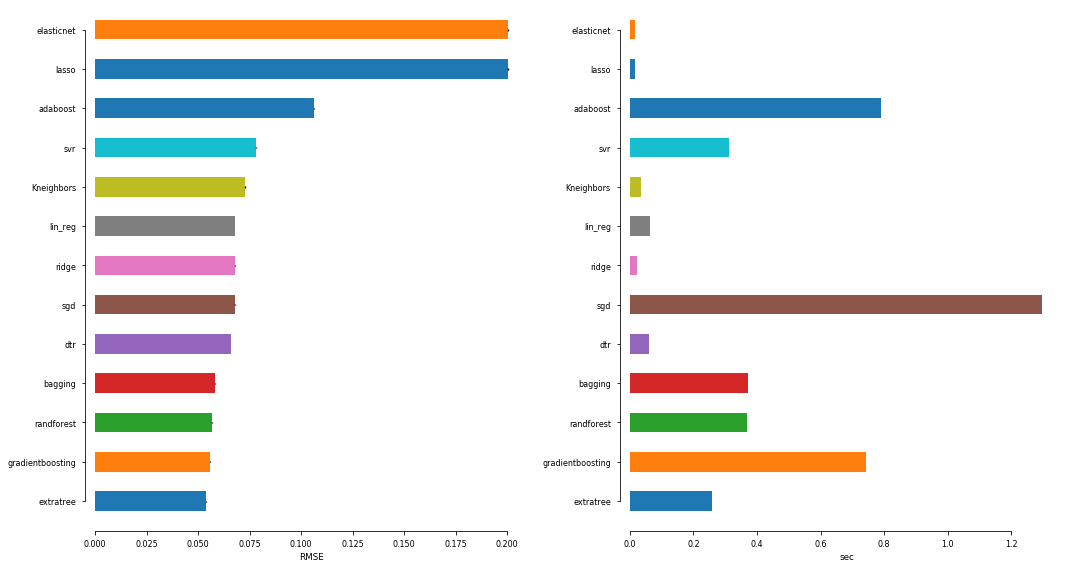

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))
metrics['mean'].plot(kind='barh', ax=ax1, yerr=metrics['std'])
ax1.set_xlabel('RMSE')
metrics['time'].plot(kind='barh', ax=ax2)
ax2.set_xlabel('sec')

sns.despine(offset=10, trim=True)
fig.tight_layout()
plt.show()

#### Outcomes
- Ensemble methods looks very promising
- top 3: _Extra Tree Regressor_, _Gradient Boosting_ and _Random Forest_
- Stochastic Gradient Descent is the slowest, because the features are not scaled

## 4. Fine-tune the model (_Extra Tree Regressor_, _Gradient Boosting_ and _Random Forest_)

### Randomized Grid Search

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [15]:
param_distrib = {}

# extra tree
param_distrib['extratree'] = {
    'n_estimators': randint(low=1, high=200),
    'criterion': ['mse', 'mae'],
    'max_features': randint(low=5, high=15),
    'bootstrap': [True, False]
}

# gradient boosting
param_distrib['gradientboosting'] = {
    'loss': ['ls', 'lad', 'huber', 'quantile'],
    'learning_rate': uniform(0.03, 0.4),
    'n_estimators': randint(low=50, high=300)
}

# random forest
param_distrib['randforest'] = {
    'n_estimators': randint(low=50, high=300),
    'criterion': ['mse', 'mae'],
    'max_features': randint(low=5, high=15),
    'bootstrap': [True, False]
}

In [16]:
n_iter = 1000

random_search_model = {
    'extratree': ExtraTreesRegressor(random_state=RANDOM_SEED),
    'gradientboosting': GradientBoostingRegressor(),
    'randforest': RandomForestRegressor(random_state=RANDOM_SEED) 
}

random_search = {}

for key, params in param_distrib.items():
    print(f'optimize {key.upper()} hyperparameters...')
    start = time.time()
    random_search[key] = RandomizedSearchCV(random_search_model[key], param_distributions=params,
                                   n_iter=n_iter, cv=5, random_state=RANDOM_SEED,
                                   scoring='neg_mean_squared_error', n_jobs=-1)
    
    random_search[key].fit(X_train, np.ravel(y_train))
    
    end = time.time()
    
    print(f'best params: {random_search[key].best_params_}')
    print(f'execution time: {end - start:.3f} sec [{n_iter} iterations]')
    
    print('-' * 10)

optimize EXTRATREE hyperparameters...
best params: {'bootstrap': False, 'criterion': 'mse', 'max_features': 7, 'n_estimators': 49}
execution time: 964.439 sec [1000 iterations]
----------
optimize GRADIENTBOOSTING hyperparameters...
best params: {'learning_rate': 0.23404223152809012, 'loss': 'huber', 'n_estimators': 155}
execution time: 166.222 sec [1000 iterations]
----------
optimize RANDFOREST hyperparameters...
best params: {'bootstrap': False, 'criterion': 'mse', 'max_features': 7, 'n_estimators': 196}
execution time: 1012.504 sec [1000 iterations]
----------


## 5. Final predictions

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

In [98]:
models, predictions = [[] for i in range(2)]

for model in random_search.keys():
    print(f'evaluating {model.upper()}...')
    
    final_model = random_search[model].best_estimator_.predict(X_test)
    
    final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
    print(f'final RMSE: {final_rmse}')
    
    final_variance = explained_variance_score(y_test, final_predictions)
    print(f'final explained variance: {final_variance}')
    
    final_r2 = r2_score(y_test, final_predictions)
    print(f'final R2: {final_r2}')
    
    models.extend([model] * X_test.shape[0])
    predictions.extend(final_predictions)
    
    print('-' * 10)

evaluating EXTRATREE...
final RMSE: 0.04929988685624174
final explained variance: 0.9315686965696365
final R2: 0.9314259335650785
----------
evaluating GRADIENTBOOSTING...
final RMSE: 0.04929988685624174
final explained variance: 0.9315686965696365
final R2: 0.9314259335650785
----------
evaluating RANDFOREST...
final RMSE: 0.04929988685624174
final explained variance: 0.9315686965696365
final R2: 0.9314259335650785
----------


In [192]:
n_models = len(random_search.keys())

# one-hot encoding to plain
MUSCLES_COLUMNS = list(X_test.columns[:11])
muscles = X_test[MUSCLES_COLUMNS].idxmax(1)

final = pd.DataFrame({
    'models': models,
    'predictions': predictions,
    'labels': np.tile(y_test.iloc[:, 0], 3),
    'muscles': np.tile(muscles, 3)
})

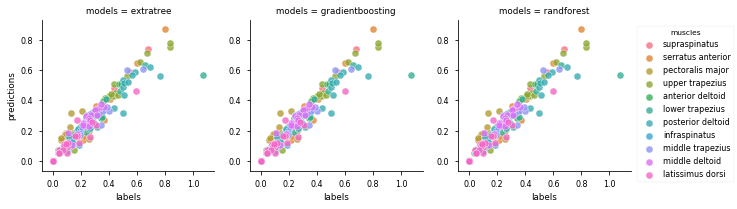

In [236]:
params = dict(s=50, linewidth=.5, edgecolor="w", alpha=.8)

plt.figure(figsize=(45, 10))
g = sns.FacetGrid(final, col='models', hue='muscles')
g = (g.map(plt.scatter, 'labels', 'predictions', **params)).add_legend()
plt.show()

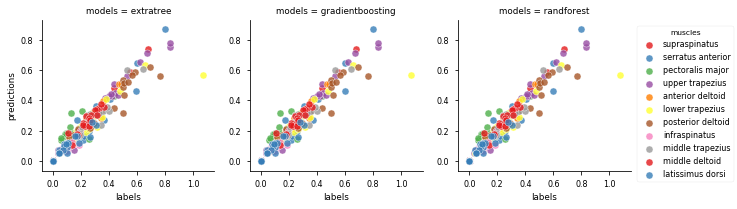

In [220]:
kws = dict(s=50, linewidth=.5, edgecolor="w", alpha=.8)

g = sns.FacetGrid(final, col='models', hue='muscles', palette="Set1")
g = (g.map(plt.scatter, 'labels', 'predictions', **kws).add_legend())
plt.show()

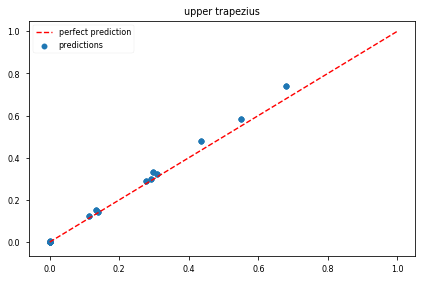

In [202]:
ti = MUSCLES_COLUMNS[6]

baseline = (0, 1)
plt.plot(baseline, 'r--', label='perfect prediction')

xi = final[final['muscles'] == 'supraspinatus']

plt.scatter(x=xi['labels'], y=xi['predictions'])

plt.title(MUSCLES_COLUMNS[0])

plt.legend()
plt.tight_layout()
plt.show()